# Réchauffement climatique et flux touristiques en France sur les années 2010
Manon Chevallier, Sara Chikhi, Inza Ouada Soro

# Table des matières
* [1. Import des données](#chapter1)
    * [1.1. Justification du champ](#section_1_1)
    * [1.2. Données climatiques](#section_1_2)
    * [1.3. Données touristiques](#section_1_3)
    * [1.4. Jointure](#section_1_4)
* [2. Statistiques descriptives](#chapter2)
    * [2.1. Statistiques sur le climat](#section_2_1)
        * [2.1.1. Variabilité climatique sur le territoire](#sub_section_2_1_1)
        * [2.1.2. Evolution dans le temps](#sub_section_2_1_2)
    * [2.2. Statistiques sur le tourisme](#section_2_1)
        * [2.2.1. Répartition du tourisme sur le territoire](#sub_section_2_2_1)
        * [2.2.2. Evolution des fréquentations touristiques](#sub_section_2_2_2)
    * [2.3. Corrélations](#section_2_1)
* [3. Modélisation](#chapter3)
    * [Présentation du modèle](#section_3_1)
    * [Résultats](#section_3_2)
* [4. Conclusion](#chapter4)


Un certain nombre de programmes ne sont pas rédigés dans ce notebook mais seulement appelés par celui-ci. Ils sont lisibles dans le dossier src.

Tous les packages nécessaires à nos programmes et leurs versions associées sont repertoriés dans requirements.txt.

## 1. Import des données <a class="anchor" id="chapter1"></a>

In [1]:
import time
t0 = time.perf_counter()

In [2]:
import os
from IPython.display import clear_output
print(os.getcwd())

/Users/sarachikhi/Project


Nous utilisons des données climatiques issues de météo france et des données sur les fréquentations touristiques issues d'une enquête mensuelle auprès des établissements touristiques. Ces deux sources de données sont importées à partir d'internet. Les codes permettant d'importer ces données se trouvent dans le dossier src/import_data. 

In [3]:
from src import import_data
%run src/import_data/api_donnees_climat.py
%run src/import_data/api_donnees_tourisme.py

Fichier climat sauvegardé dans : /Users/sarachikhi/Project/Data/data_climat.csv
Fichier tourisme sauvegardé dans : /Users/sarachikhi/Project/Data/data_tourisme.csv
Fichier tourisme sauvegardé dans : /Users/sarachikhi/Project/Data/data_tourisme2.csv


Ce dossier comporte deux scripts (api_donnees_climat et api_donnees_tourisme) qui chacun importent les données et les retraitent légèrement pour qu'elles soient cohérentes entre elles. En particulier, il faut qu'elles soient toutes deux au niveau départemental, annuel et mensuel. Chaque ligne de notre table de données correspondra donc à un département x une année x un mois. Nous produisons également une troisième base (data_tourisme2) comprenant l'origine des touristes, que nous traiterons plus tard.

### 1.1. Justification du champ <a id="section_1_1"></a>

#### Champ géographique
Nous nous concentrons sur les données métropolotaines et Corse, et excluons les départements et régions d'outre-mer. Deux raisons principales expliquent ce choix. D'abord, ce sont des régions au climat différent (tropical) de celui de la France métropolitaine (continental). La spécificité de ces régions aurait nécessité une analyse à part ce qui aurait complexifié les analyses. Par ailleurs, les voyages en outre-mer sont de nature différente de ceux sur le territoire métropolitain ou Corse, en particulier, ils sont beaucoup plus couteux financièrement. Nous faisons donc comme hypothèse que le choix de ces destinations est moins sensible à des considérations climatiques, s'organisant probablement de plus longue haleine que des voyages métropolitains. 

Nous avons opté pour la granularité géographique départementale. Il nous semblait en effet qu'elle était suffisamment précise pour distinguer les zones littorales et montagneuses des autres, contrairement à l'échelle régionale. Nous nous sommes assurés de la représentativité des résultats au niveau régional en contactant directement l'une des productrices de ces données travaillant à l'Insee (Jeanne Pages).

#### Champ temporel
La période temporelle retenue court de janvier 2011 à décembre 2019. La raison de ce choix se trouve en partie dans des contraintes techniques (les données touristiques n'étant disponible qu'à partir de 2011) mais elle nous a paru pertinente pour répondre à notre problématique, et ce pour trois raisons. D'abord, les décisions de destinations touristiques se font généralement au cours de l'année, en prenant en compte les quelques années précédentes, voire l'année précédente seulement. Ainsi, en adoptant une période de près de 10 ans, nous avons suffisamment d'observations différentes pour avoir des résultats. Ensuite, la décennie des années 2010 est intéressante car elle a vu s'intensifier les épisodes climatiques de façon assez nette : "Sur les 51 vagues de chaleur recensées depuis 1947 à l'échelle nationale : 25 ont eu lieu entre 1947 et 2010 ; 26 ont eu lieu depuis 2011." d'après Météo-France. Enfin, nous avons choisi de ne pas sélectionner les années ultérieures à 2019 en raison de la crise sanitaire qui a fortement perturbé les flux touristiques. 

### 1.2. Données climatiques <a id="section_1_2"></a>

On importe les données climatiques en ne sélectionnant que nos variables d'intérêt, c'est-à-dire celles permettant d'obtenir la température moyenne, les températures maximales et les évènements de forte chaleur ou de forte froideur (voir api_donnees_climat). On analyse les valeurs manquantes.


In [4]:
import pandas

data_1 = pandas.read_csv("./Data/data_climat.csv")
data_1["DEP"] = data_1["DEP"].astype(str).str.zfill(2)
colonnes_climat = data_1.columns.values[2:len(data_1.columns.values)]

for i in colonnes_climat:
    nul = data_1[data_1[i].isnull()]
    print("Lignes comportant des valeurs manquantes pour la variable", i, ":")
    print(nul.DEP.unique())
    print(nul.AAAA.unique())
    print(nul.MM.unique())

Lignes comportant des valeurs manquantes pour la variable TM :
['92' '93']
[2019 2013]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable TX :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX0 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX25 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX30 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX35 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJNEIG :
['01' '05' '07' '08' '11' '15' '21' '24' '25' '32' '37' '39' '43' '45'
 '46' '55' '57' '66' '67' '70' '72' '73' '74' '79' '88' '90' '92' '93'
 '94']
[2022 2011 2012 2021 2017 2018 2019 2020 2013 2014 2015 2016]
[10  8  6  5  9  7 11 12  3  4  1  2]
Lignes comportant 

Seuls les départements 92 et 93 comportent des valeurs manquantes pour la plupart des variables climatiques d'intérêt. Puisque ce sont principalement les zones littorales et montagneuses qui nous intéressent, c'est peu gênant. Cependant, la variable du nombre de jour de neige est absente pour un certain nombre de départements. Cela peut poser problème en particulier pour les départements montagneux des Alpes (05, 73, 74), du Massif Central (15, 43), du Jura (25, 39), des Pyrénées (66). Regardons plus en détail les mois et années concernées.

In [5]:
dept_montagne_manquants = ["05", "73", "74", "15", "43", "25", "39", "66"]

data_dep = data_1.loc[data_1["DEP"].isin(dept_montagne_manquants)]
nul = data_dep[data_dep["NBJNEIG"].isnull()]
print(nul.DEP.unique())
print(nul.AAAA.unique())
print(nul.MM.unique())


['05' '15' '25' '39' '43' '66' '73' '74']
[2011 2012 2021 2022 2019 2018 2020 2017]
[ 8  6  5  9 10  7  4]


Aucun mois d'hiver n'est concerné. Ces données manquantes ne poseront pas problème.

### 1.3. Données touristiques <a id="section_1_3"></a>

On importe les données touristiques. Pour quantifier les "fréquentations touristiques" nous avions le choix entre plusieurs types de variables, notamment le nombre de nuitées ou le nombre d'arrivées. Nous avons sélectionné uniquement le nombre d'arrivées, plus pertinent pour approcher le choix d'une destination (on aurait également pu s'intéresser aux effets du climat sur la longueur des séjours mais nous faisons l'hypothèse que l'effet du climat sur cette décision est moins fort que pour le choix de la destination). On analyse les valeurs manquantes.

In [6]:
data_2 = pandas.read_csv("./Data/data_tourisme.csv")
data_2["DEP"] = data_2["DEP"].astype(str).str.zfill(2)

null_data = data_2[data_2.isnull().any(axis=1)]
print(null_data)


Empty DataFrame
Columns: [AAAA, MM, DEP, DEP_NOM, OBS_VALUE_CORR]
Index: []


On va faire la même chose avec data_tourisme2 qui est la base de données prenant en compte l'origine des touristes (chaque ligne département x années x mois est dédoublée avec une ligne pour les touristes étrangers et une ligne pour les touristes français).

In [7]:
data_3 = pandas.read_csv("./Data/data_tourisme2.csv")
data_3["DEP"] = data_3["DEP"].astype(str).str.zfill(2)

null_data = data_3[data_3.isnull().any(axis=1)]
print(null_data)

Empty DataFrame
Columns: [AAAA, MM, DEP, DEP_NOM, TOUR_RESID, OBS_VALUE_CORR]
Index: []


### 1.4. Jointure <a id="section_1_4"></a>

On effectue une jointure à gauche (sur les données climatiques). On vérifie de nouveau qu'il n'existe pas de valeurs manquantes sur nos indicateurs d'intérêt ; cela peut arriver si tous les départements ou toutes les années ne sont pas présents dans les deux tables par exemple.

In [8]:
df = pandas.merge(data_1, data_2, on=["DEP", "AAAA", "MM"], how="left")

print("Liste des départements, années et mois dans la table mergée :")
print(df.DEP.unique())
print(df.AAAA.unique())
print(df.MM.unique())

nul_data1 = df[df['TX'].isnull()]
nul_data2 = df[df['OBS_VALUE_CORR'].isnull()]

print("Valeurs manquantes de température dans les données finales :")
print(nul_data1.DEP.unique())
print(nul_data1.AAAA.unique())
print(nul_data1.MM.unique())
df.to_csv("base.csv")

print("Valeurs manquantes d'arrivées dans les données finales :")
print(nul_data2.DEP.unique())
print(nul_data2.AAAA.unique())
print(nul_data2.MM.unique())

Liste des départements, années et mois dans la table mergée :
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '2A' '2B']
[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Valeurs manquantes de température dans les données finales :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Valeurs manquantes d'arrivées dans les données finales :
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '

On observe que les arrivées touristiques sont manquantes pour la période du Covid-19. Comme prévu, on va donc exclure les années concernées pour ne pas biaiser les résultats. 

In [9]:
df = df.loc[df["AAAA"] < 2020] 
df.to_csv("base.csv")
print(df.tail())

       AAAA  MM         TM         TX    NBJTX0    NBJTX25    NBJTX30  \
13783  2019   8  23.843636  29.210909  0.000000  28.418182  14.200000   
13784  2019   9  20.554545  25.580000  0.000000  19.490909   2.781818   
13785  2019  10  17.203571  21.666071  0.000000   4.839286   0.339286   
13786  2019  11  10.882143  13.948214  0.500000   0.017857   0.000000   
13787  2019  12  10.045455  13.414286  0.267857   0.000000   0.000000   

       NBJTX35   NBJNEIG DEP saison     periode DEP_NOM  OBS_VALUE_CORR  
13783      0.8  0.000000  2B    été  apres_2015   Corse        114930.0  
13784      0.0  0.000000  2B    été  apres_2015   Corse        105880.0  
13785      0.0  0.000000  2B  Other  apres_2015   Corse         45840.0  
13786      0.0  0.100000  2B  Other  apres_2015   Corse         11650.0  
13787      0.0  0.083333  2B  hiver  apres_2015   Corse          9290.0  


## 2. Statistiques descriptives <a id="chapter_2"></a>

La plupart des statistiques descriptives seront présentées sous forme de carte.



In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

### 2.1. Statistiques sur le climat <a id="section_2_1"></a>


#### 2.1.1. Variabilité climatique sur le territoire <a id="section_2_1_1"></a>

Notre problématique est adaptée au territoire français car celui-ci présente une forte variabilité climatique sur le territoire, comme le montrent les cartes suivantes.

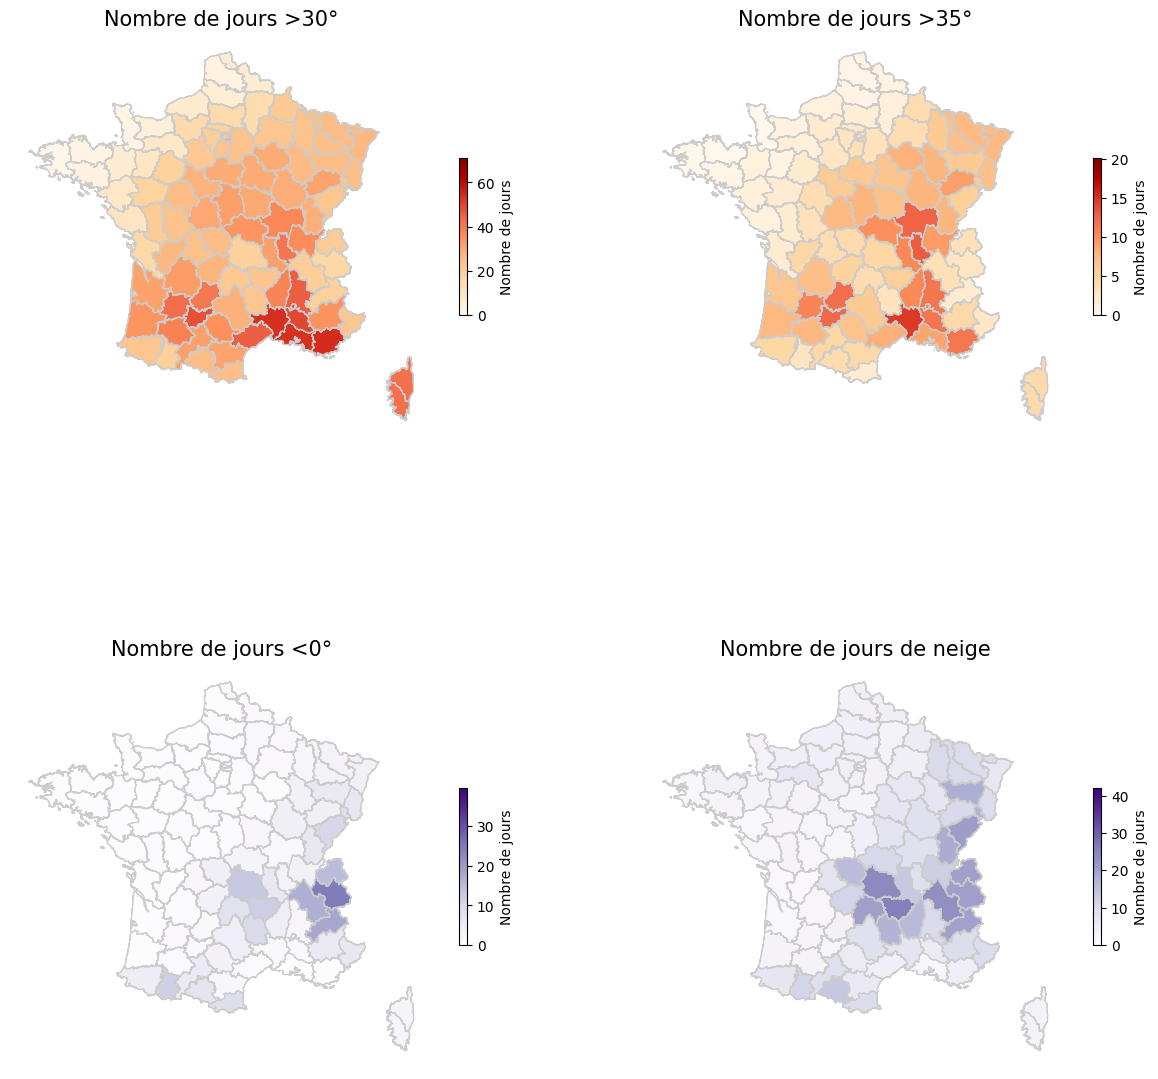

In [11]:
# TEMPS APPROXIMATIF : 40sec
# parametres
mois_ete = [6, 7, 8, 9]
mois_hiver = [1,2,3,12]
toutes_annees = [i for i in range(2011, 2020)]

from src.package_project import cartes, indicateurs_climat

# construction des cartes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  
cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX30")),
            toutes_annees,
            mois_ete,
            indicateur = "NBJTX30",
            titre_carte = "Nombre de jours >30°",
            titre_axe = "Nombre de jours",
            plotting = ax[0,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Nombre de jours >35°",
            titre_axe = "Nombre de jours",
            plotting = ax[0,1],
            evolution = False)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Nombre de jours <0°",
            titre_axe = "Nombre de jours",
            plotting = ax[1,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Nombre de jours de neige",
            titre_axe = "Nombre de jours",
            plotting = ax[1,1],
            evolution = False)



Nous observons que les zones les plus impactées par les fortes chaleur sont le littoral méditerranéen, les alentours du Rhone (à l'ouest de Lyon) et au milieu de la Garonne (départements du Tarn-et-Garonne et Lot-et-Garonne). Nous serons particulièrement attentifs aux évolutions du tourisme sur le littoral, étant donné qu'il s'agit d'une zone fortement touristique.

Les zones les plus froides se situent dans les Alpes. Avec le Massif Central, ce sont aussi celles les plus concernées par l'enneignement. 

Intéressons-nous à l'évolution de ces conditions climatiques au cours de la décennie 2010.

#### 2.1.2. Evolution dans le temps <a id="section_2_1_2"></a>

On s'intéresse maintenant à l'évolution du climat dans le temps. 

In [12]:
from src.package_project.Carte_dyn import gif
from IPython.display import display, HTML

gif("hiver")
gif("été")

html = """
<div style="display:flex;">
    <img src="cart_pour_les hiver.gif" style="width:500px;"/>
    <img src="cart_pour_les été.gif" style="width:500px;"/>
</div>
"""

display(HTML(html))

In [13]:
t1 = time.perf_counter()
print(f"Temps d'affichage : {t1 - t0:.3f}s")

Temps d'affichage : 91.746s


Ces cartes dynamiques nous permettent de constater que s'il y a une tendance au réchauffement entre 2011 et 2022 (en particulier l'été), il y a une certaine variabilité selon les années. 

Intéressons nous aux évènements extrèmes (forte chaleur ou températures basses). Pour lisser les variations annuelles, on s'intéresse à l'évolution de la moyenne du nombre annuel de jours extremes, entre avant 2015 (inclus) et après 2015 (non inclus.)

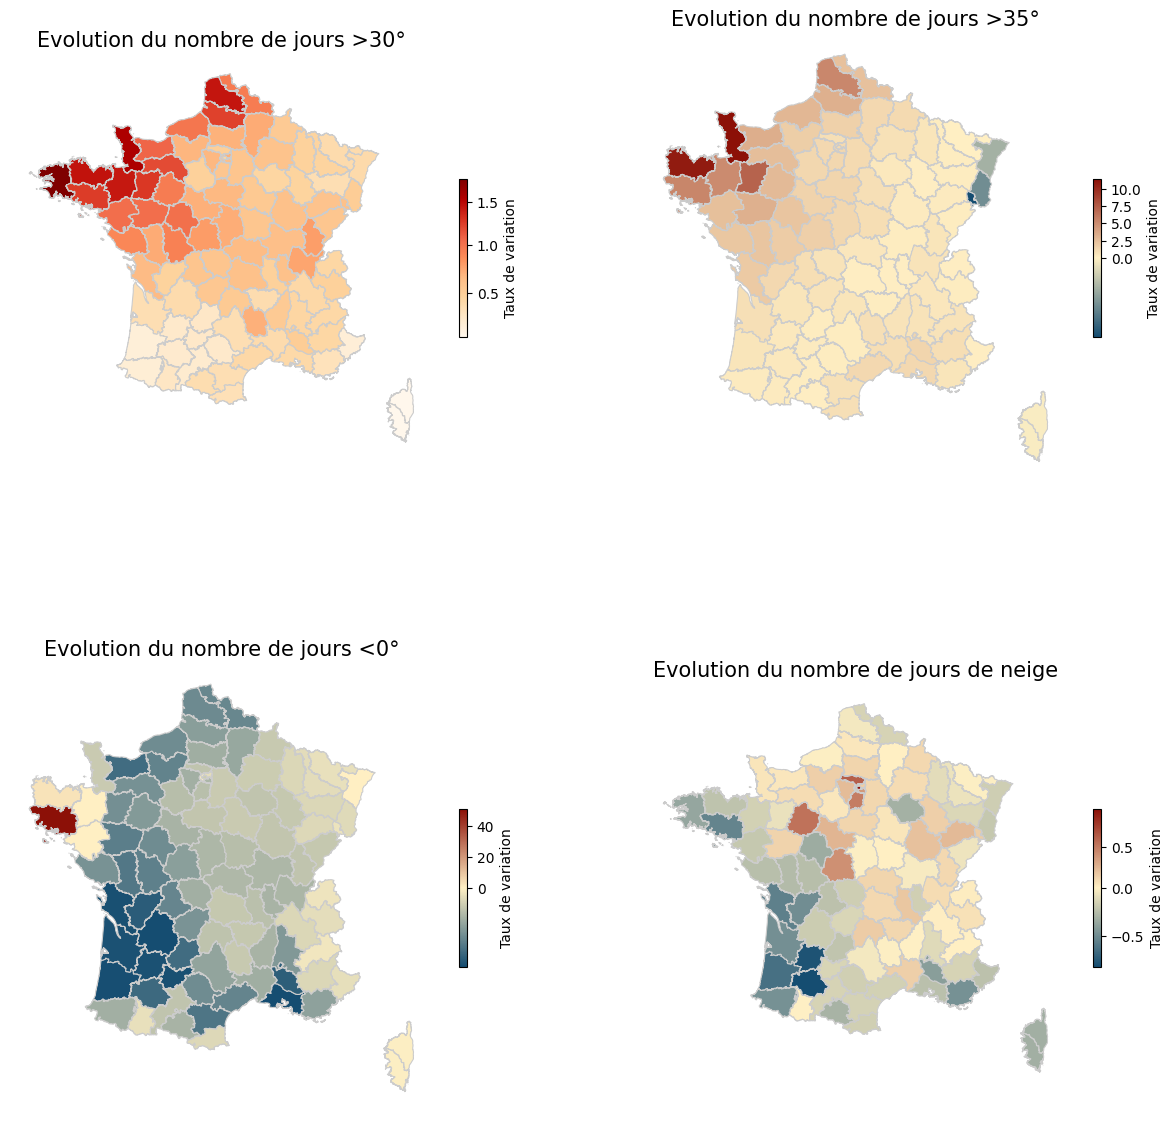

In [14]:
# évolution des évènements extremes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX30")),
            toutes_annees,
            mois_ete,
            "NBJTX30",
            "Evolution du nombre de jours >30°",
            titre_axe = "Taux de variation",
            plotting = ax[0,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Evolution du nombre de jours >35°",
            titre_axe = "Taux de variation",
            plotting = ax[0,1],
            evolution = True)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Evolution du nombre de jours <0°",
            titre_axe = "Taux de variation",
            plotting = ax[1,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Evolution du nombre de jours de neige",
            titre_axe = "Taux de variation",
            plotting = ax[1,1],
            evolution = True)

On observe d'abord que le nombre de jours annuels moyens de plus de 30° a augmenté entre avant 2015 et après 2015 sur l'ensemble du territoire. Une zone se démarque largement (la Bretagne), en raison de la faiblesse du nombre de jours chauds à l'origine dans cette zone comme le montrent les cartes précédentes. 

Le constat est relativement similaire pour les jours à plus de 35°, excepté pour les zones du Haut-Rhin et du Bas-Rhin caractérisées par une diminution de ces fortes chaleurs. 

Les zones littorales Atlantique (sous la Bretagne) et méditerrannée voient ces épisodes augmenter mais de manière similaire au reste du territoire. 

Le nombre annuel moyen de jours à moins de 0 degrés a diminué entre avant et après 2015 sur presque tout le territoire, excepté à nouveau en Bretagne. La tendance est moins claire pour les jours de neige, notamment sur les zones montagneuses.

### 2.2. Statistiques sur le tourisme <a id="section_2_2"></a>

#### 2.2.1. Répartition du tourisme sur le territoire <a id="section_2_2_1"></a>

Intéressons-nous à la répartition du tourisme sur le territoire français. Les cartes suivantes présentes la répartition du total des arrivées entre 2011 et 2019, en été et en hiver.

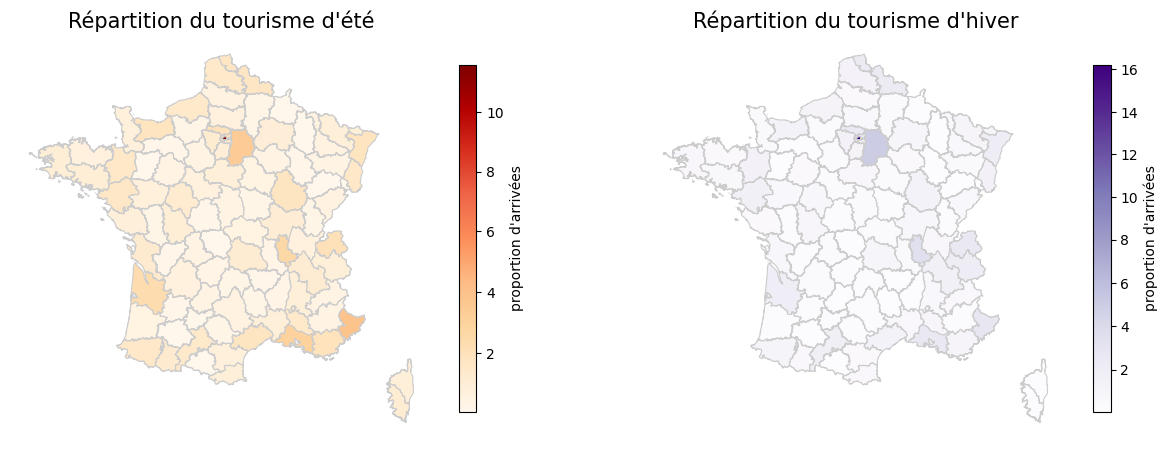

In [15]:
from src.package_project import indicateurs_tourisme

fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_ete, ["DEP"])),
            toutes_annees,
            mois_ete,
            "part_tourisme",
            "Répartition du tourisme d'été",
            titre_axe = "proportion d'arrivées",
            plotting = ax[0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_hiver, ["DEP"])),
            toutes_annees,
            mois_hiver,
            "part_tourisme",
            "Répartition du tourisme d'hiver",
            titre_axe = "proportion d'arrivées",
            plotting = ax[1],
            evolution = False)



Alors que l'on pouvait s'attendre à une répartition peu équilibrée surle territoire, on observe une relative stabilité excepté sur le département parisien : la capitale absorbe une grande part du tourisme d'été ou d'hiver. Pour avoir une meilleure visibilité du tourisme littoral et montagneux, on exclut la région parisienne. 

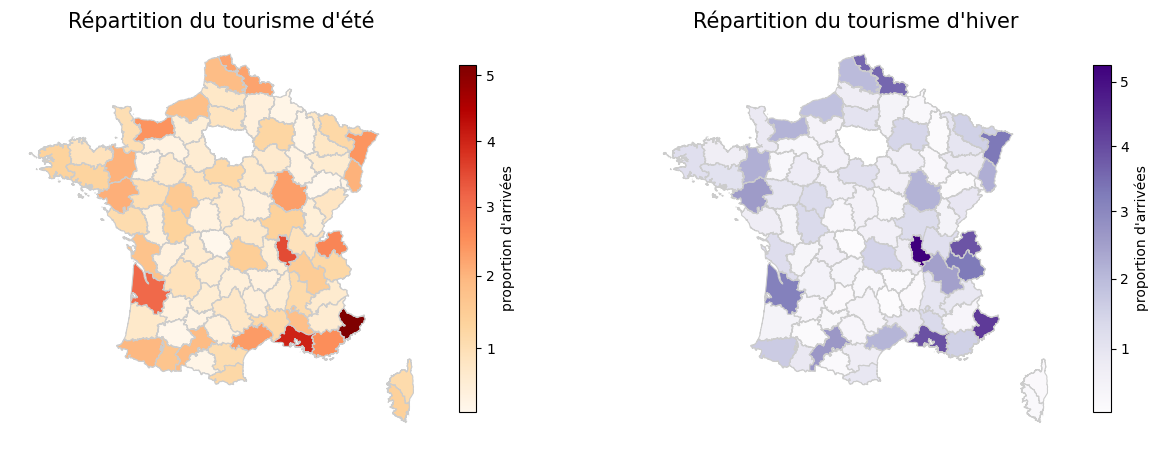

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

df_hors_idf = df.loc[~df["DEP"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df_hors_idf, toutes_annees, mois_ete, ["DEP"])),
            toutes_annees,
            mois_ete,
            "part_tourisme",
            "Répartition du tourisme d'été",
            titre_axe = "proportion d'arrivées",
            plotting = ax[0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df_hors_idf, toutes_annees, mois_hiver, ["DEP"])),
            toutes_annees,
            mois_hiver,
            "part_tourisme",
            "Répartition du tourisme d'hiver",
            titre_axe = "proportion d'arrivées",
            plotting = ax[1],
            evolution = False)

Que ce soit pour l'été ou l'hiver, la répartition du tourisme (hors Ile-de-France) est inégalement répartie sur le territoire. Les zones littorales et montagneuses accueillent davantage de touristes que le centre de la France. 

La comparaison du tourisme d'été et d'hiver met en évidence un tourisme plus important sur le littoral l'été que l'hiver. 

Il est intéressant néanmoins de noter que la répartition reste proche entre l'été et l'hiver, malgré des conditions climatiques différentes. Une hypothèse pouvant l'expliquer est le fait qu'une partie du tourisme serait en réalité des déplacements non-touristiques (fréquentation d'un hôtel pour raison professionnelle par exemple). Dans ce cas, la répartition touristique est fortement influencée par l'activité économique des départements.

Si cette hypothèse est vérifiée, il est probable que les données donnent une corrélation assez faible entre fréquentation touristique et évolution du climat, a minima sur les départements non côtiers ou montagneux.

#### 2.2.2. Evolution des fréquentations touristiques <a id="section_2_2_2"></a>


On s'intéresse maintenant à l'évolution des fréquentations touristiques entre 2011 et 2019.

In [17]:
mois=mois_ete

data = pandas.DataFrame(df.loc[df['MM'].isin(mois)].groupby(["DEP", "periode","AAAA"])["OBS_VALUE_CORR"].sum())
df2=data.groupby(["DEP","periode"]).mean()
df2 = df2.reset_index()
df2 = df2.pivot(index="DEP", columns="periode", values="OBS_VALUE_CORR")
df2 = df2.reset_index(names=["DEP"])
df2["evol_2015"] = np.where(df2['avant_2015']!= 0, 
                     (df2.apres_2015 - df2.avant_2015)/df2.avant_2015, 
                                 np.nan)

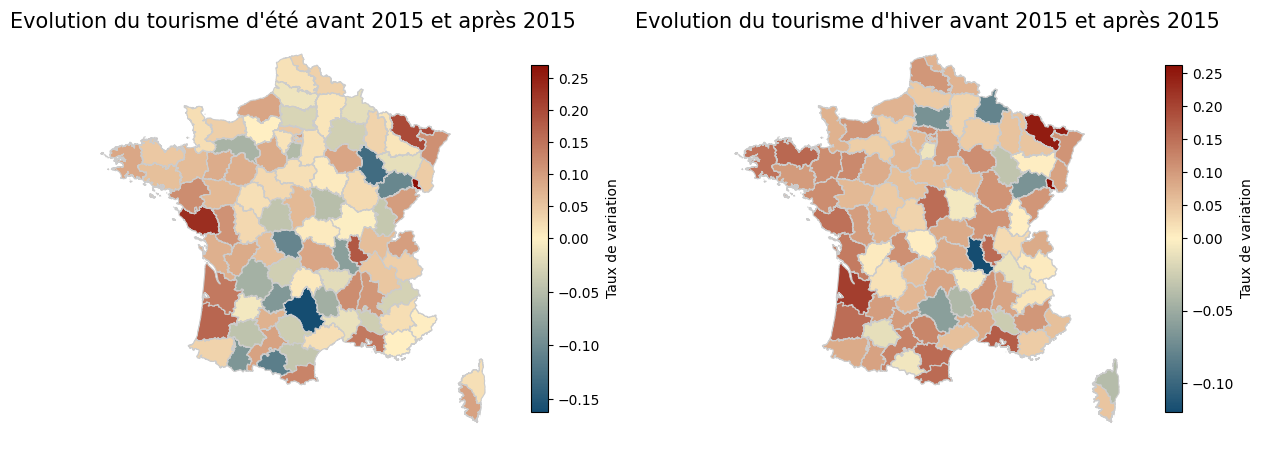

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_ete)),
            toutes_annees,
            mois_ete,
            "evol_2015",
            "Evolution du tourisme d'été avant 2015 et après 2015",
            "Taux de variation",
            ax[0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_hiver)),
            toutes_annees,
            mois_hiver,
            "evol_2015",
            "Evolution du tourisme d'hiver avant 2015 et après 2015",
            "Taux de variation",
            ax[1],
            evolution = True)

Ces deux cartes présentent le taux de variation du nombre annuel moyen d'arrivées touristiques par département, entre avant 2015 et après 2015. 

### 2.3. Corrélations <a id="section_2_3"></a>

Nous allons calculer le coefficient de corrélation global avant de s'intéresser aux coefficients de corrélation par département et par saison

In [ ]:
col_arrivees = "OBS_VALUE_CORR"
col_temp = "TX"

base_clean = df.dropna(subset=[col_arrivees, col_temp]).copy()

corr_global = base_clean[col_arrivees].corr(base_clean[col_temp], method="pearson")
print("Corrélation globale arrivées / TX :", corr_global)

Corrélation globale arrivées / TX : 0.1302392795629513


Nous calculons le coefficient de corrélation linéaire de Pearson entre le nombre d'arrivée touristiques (OBS_VALUE_CORR) et la température maximale moyenne mensuelle (TX) sur l'ensemble des départements et des périodes. 
Le coefficient de corrélation globale est 0.15, ce qui traduit un lien positif mais faible entre les deux variables : les hausses de températures s'accompagnent en moyenne d'une légère hausse des arrivées, sans que le climat ne soit le déterminant principal des flux. 

Nous qualifions de forte une corrélation lorsque |r|≥0.5 et nous affichons uniquement les départements présentant une corrélation fortement positive (r≥0.5) ou fortement négative (r≤−0,5).

In [ ]:
# Par Département
corr_par_dep = (
    base_clean
    .groupby("DEP")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

dep_corr_forte_pos = corr_par_dep[corr_par_dep["corr_arrivees_TX"] >= 0.75]
liste_dep_forte_positive = corr_par_dep.loc[corr_par_dep["corr_arrivees_TX"] >= 0.75, "DEP"].tolist()
dep_corr_forte_neg = corr_par_dep[corr_par_dep["corr_arrivees_TX"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_pos)
print(liste_dep_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_neg)

Départements à corrélation fortement POSITIVE :
   DEP  corr_arrivees_TX
2   03          0.882257
3   04          0.916236
5   06          0.878120
6   07          0.931762
7   08          0.787799
..  ..               ...
83  83          0.967116
84  84          0.925867
85  85          0.897433
87  87          0.868016
89  89          0.916854

[68 rows x 2 columns]
['03', '04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '32', '33', '34', '35', '36', '37', '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '55', '56', '58', '61', '62', '63', '64', '65', '66', '71', '72', '76', '79', '80', '81', '82', '83', '84', '85', '87', '89']

Départements à corrélation fortement NÉGATIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_TX]
Index: []


In [ ]:
# Par Département
corr_par_dep = (
    base_clean
    .groupby("DEP")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

dep_corr_forte_pos = corr_par_dep[corr_par_dep["corr_arrivees_TX"] >= 0.75]
liste_dep_forte_positive = corr_par_dep.loc[corr_par_dep["corr_arrivees_TX"] >= 0.75, "DEP"].tolist()
dep_corr_forte_neg = corr_par_dep[corr_par_dep["corr_arrivees_TX"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_pos)
print(liste_dep_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_neg)



Départements à corrélation fortement POSITIVE :
   DEP  corr_arrivees_TX
2   03          0.882257
3   04          0.916236
5   06          0.878120
6   07          0.931762
7   08          0.787799
..  ..               ...
83  83          0.967116
84  84          0.925867
85  85          0.897433
87  87          0.868016
89  89          0.916854

[68 rows x 2 columns]
['03', '04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '32', '33', '34', '35', '36', '37', '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '55', '56', '58', '61', '62', '63', '64', '65', '66', '71', '72', '76', '79', '80', '81', '82', '83', '84', '85', '87', '89']

Départements à corrélation fortement NÉGATIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_TX]
Index: []


In [ ]:
# Par Saison
corr_par_saison = (
    base_clean
    .groupby("saison")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par saison :")
print(corr_par_saison)

# Par Période
corr_par_periode = (
    base_clean
    .groupby("periode")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par période :")
print(corr_par_periode)



Corrélation arrivées / TX par saison :
  saison  corr_arrivees_TX
0  Other          0.073182
1  hiver          0.014088
2    été          0.056232

Corrélation arrivées / TX par période :
      periode  corr_arrivees_TX
0  apres_2015          0.124142
1  avant_2015          0.137920


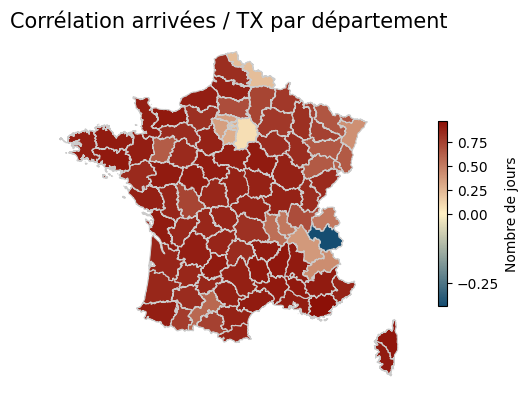

In [ ]:
corr_dep = corr_par_dep.copy()
corr_dep["DEP"] = corr_dep["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_ete
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep),
    annees=toutes_annees,
    mois=mois_ete,
    indicateur= "corr_arrivees_TX", 
    titre_carte= "Corrélation arrivées / TX par département", 
    titre_axe = "coefficient de corrélation",
    plotting=ax, 
    evolution=False
)

Nous allons créer un nouvel indicateur reliant les arrivées touristiques de l’année N à un indice de chaleur estivale décalé d’un an (N−1), afin d’intégrer l’idée que les décisions de voyage peuvent dépendre des conditions climatiques observées l’année précédente. 

Tout d'abord, nous allons construire l’indice de chaleur annuel par département.

In [ ]:
import pandas as pd

# On part de df = base climat + tourisme fusionnée
df_ind = df.copy()

# Mois d'été
mois_ete = [6, 7, 8, 9]

# On garde seulement l'été
df_ete = df_ind[df_ind["MM"].isin(mois_ete)].copy()

# Indice de chaleur mensuel (pondération des jours très chauds)
df_ete["indice_chaleur_mensuel"] = (
    df_ete["NBJTX25"].fillna(0)
    + df_ete["NBJTX30"].fillna(0)
    + 2 * df_ete["NBJTX35"].fillna(0)
)

# Agrégation annuelle par département :
# - somme des arrivées
# - somme de l'indice de chaleur sur les mois d'été
base_ind = (
    df_ete
    .groupby(["DEP", "AAAA"], as_index=False)
    .agg(
        arrivees=("OBS_VALUE_CORR", "sum"),
        indice_chaleur=("indice_chaleur_mensuel", "sum")
    )
)

base_ind.head()

,DEP,AAAA,arrivees,indice_chaleur
0,01,2011,288060.0,72.750000
1,01,2012,310260.0,80.375000
2,01,2013,325860.0,81.559289
3,01,2014,337270.0,62.249012
4,01,2015,319150.0,121.833333


Maintenant, nous allons construire l'indicateur climat N-1

In [ ]:
# On s'assure que les lignes sont bien triées
base_ind = base_ind.sort_values(["DEP", "AAAA"])

# Pour chaque département, on décale l'indice de chaleur d'une année
base_ind["indice_chaleur_N_1"] = (
    base_ind
    .groupby("DEP")["indice_chaleur"]
    .shift(1)     # année précédente
)

# On enlève les années où on n'a pas encore de N-1 (première année de chaque DEP)
base_lag = base_ind.dropna(subset=["indice_chaleur_N_1"]).copy()

base_lag.head()

,DEP,AAAA,arrivees,indice_chaleur,indice_chaleur_N_1
1,01,2012,310260.0,80.375000,72.750000
2,01,2013,325860.0,81.559289,80.375000
3,01,2014,337270.0,62.249012,81.559289
4,01,2015,319150.0,121.833333,62.249012
5,01,2016,330540.0,101.875000,121.833333


Nous allons maintenant calculer la corrélation globale arrivées N vs indice chaleur N-1.

In [ ]:
corr_global_lag = base_lag["arrivees"].corr(
    base_lag["indice_chaleur_N_1"],
    method="pearson"
)

print("Corrélation globale arrivées (année N) / indice de chaleur (année N-1) :",
      corr_global_lag)

Corrélation globale arrivées (année N) / indice de chaleur (année N-1) : -0.007356966468066168


Nous avons construit un indicateur de « chaleur estivale » en année N–1, défini comme une combinaison pondérée du nombre de jours avec des températures maximales supérieures à 25 °C, 30 °C et 35 °C, agrégé par département et par année. Nous avons ensuite calculé la corrélation entre cet indice de chaleur en année N–1 et le nombre d’arrivées touristiques en année N.

La corrélation obtenue est très faible : ρ ≈ –0,007. Une valeur aussi proche de zéro signifie qu’il n’existe pratiquement aucune relation linéaire entre la chaleur de l’été précédent et les flux touristiques observés l’année suivante, au niveau départemental. Le signe légèrement négatif n’a pas d’interprétation économique robuste : il est trop faible pour être considéré comme significatif et doit être vu comme une fluctuation aléatoire.

Ce résultat suggère que, dans nos données, les variations interannuelles des arrivées touristiques sont surtout déterminées par d’autres facteurs (conjoncture économique, coût du transport, effets exceptionnels comme la crise Covid, etc.), et que le niveau de chaleur de l’été précédent ne permet pas, à lui seul, d’expliquer les variations des flux touristiques départementaux.

In [ ]:
# Par département 

corr_par_dep_lag = (
    base_lag
    .groupby("DEP")
    .apply(lambda g: g["arrivees"].corr(g["indice_chaleur_N_1"], method="pearson"))
    .reset_index(name="corr_arrivees_indice_N_1")
)

corr_par_dep_lag.head()

dep_corr_forte_positive = corr_par_dep_lag[corr_par_dep_lag["corr_arrivees_indice_N_1"] >= 0.75]
liste_dep_forte_negative= corr_par_dep_lag.loc[corr_par_dep_lag["corr_arrivees_indice_N_1"] <= -0.5, "DEP"].tolist()
dep_corr_forte_negative = corr_par_dep_lag[corr_par_dep_lag["corr_arrivees_indice_N_1"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_negative)
print(liste_dep_forte_negative)


Départements à corrélation fortement POSITIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_indice_N_1]
Index: []

Départements à corrélation fortement NÉGATIVE :
   DEP  corr_arrivees_indice_N_1
10  11                 -0.552799
13  14                 -0.535390
18  19                 -0.501510
19  21                 -0.576011
21  23                 -0.599320
22  24                 -0.566927
30  30                 -0.602858
31  31                 -0.566711
36  36                 -0.543776
37  37                 -0.534843
39  39                 -0.611635
42  42                 -0.581539
48  48                 -0.591619
51  51                 -0.574837
52  52                 -0.711900
54  54                 -0.580609
58  58                 -0.530432
60  60                 -0.563600
61  61                 -0.619835
62  62                 -0.592470
80  80                 -0.617430
84  84                 -0.622068
86  86                 -0.547042
89  89                 -0.520799
91  91     

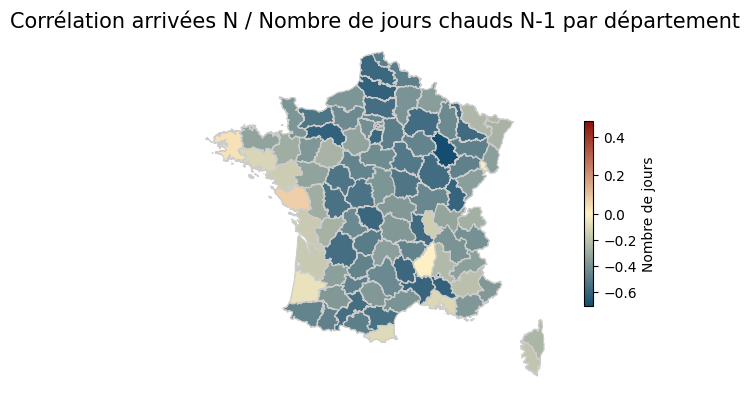

In [ ]:
corr_dep2 = corr_par_dep_lag.copy()
corr_dep2["DEP"] = corr_dep2["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_ete
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep2),
    annees=toutes_annees,
    mois=mois_ete,
    indicateur= "corr_arrivees_indice_N_1", 
    titre_carte= "Corrélation arrivées N / Nombre de jours chauds N-1 par département", 
    titre_axe = "coefficient de corrélation",
    plotting=ax, 
    evolution=False
)

La légende utilise une échelle centrée sur 0 :

- en bleu, les corrélations négatives (dans ces départements, les années précédées d’un été plus chaud tendent plutôt à être associées à des niveaux d’arrivées légèrement plus faibles) ;
- en rouge, les corrélations positives (les années précédées d’un été plus chaud sont associées à des arrivées un peu plus élevées) ;
- les tons beige / gris clair correspondants à des corrélations proches de 0, c’est-à-dire pas de lien linéaire marqué.

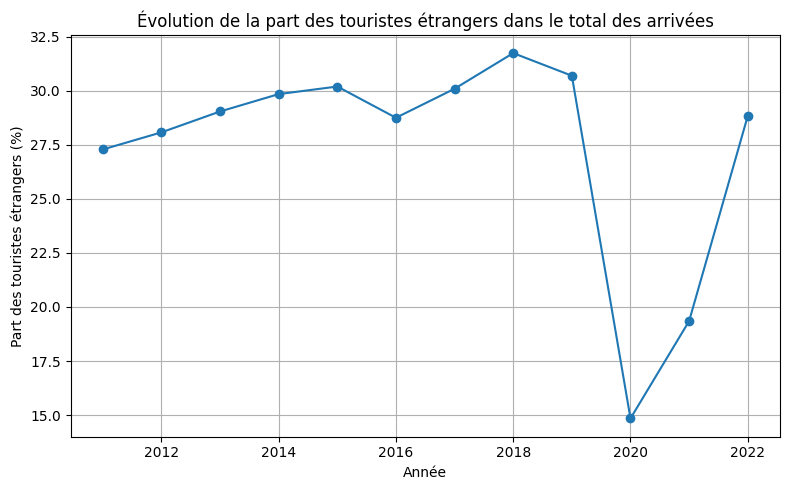

In [ ]:
tour = data_3.copy()

# 1. On agrège par année et origine du touriste
agg = (
    tour
    .groupby(["AAAA", "TOUR_RESID"], as_index=False)["OBS_VALUE_CORR"]
    .sum()
)

# 2. On met France / Étranger en colonnes
pivot = agg.pivot(index="AAAA", columns="TOUR_RESID", values="OBS_VALUE_CORR")

# Sécuriser les noms de colonnes (accents ou pas selon ta base)
pivot = pivot.rename(columns={
    "Étranger": "etranger",
    "France": "france"
})

# 3. Part des étrangers dans le total par année
pivot["part_etrangers"] = pivot["etranger"] / (pivot["etranger"] + pivot["france"])

# 4. Tracé de la courbe
plt.figure(figsize=(8, 5))
plt.plot(pivot.index, 100 * pivot["part_etrangers"], marker="o")
plt.xlabel("Année")
plt.ylabel("Part des touristes étrangers (%)")
plt.title("Évolution de la part des touristes étrangers dans le total des arrivées")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Modélisation <a id="chapter_3"></a>
### 3.1. Présentation du modèle <a id="section_3_1"></a>


A COMPLETER

### 3.2. Présentation du modèle <a id="section_3_2"></a>


DÉPARTEMENT : Allier

#1) Préparation des données
DÉPARTEMENT 03
2011 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2012 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2013 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2014 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2015 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2016 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2017 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2018 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2019 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2020 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2021 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2022 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

NOTE MÉTHODOLOGIQUE
- Données postérieures à 2020 exclues (crise sanitaire)
- Mois manquants interpolés par méthode temporelle
- Flux touristique transformé en logarithme

#2) An

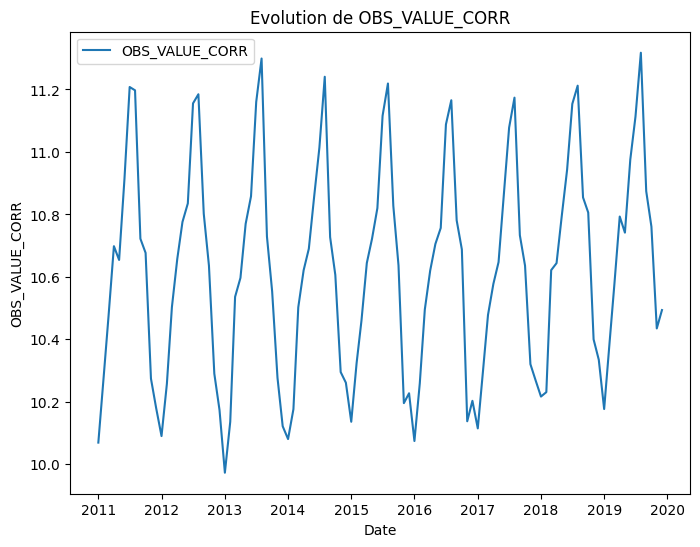

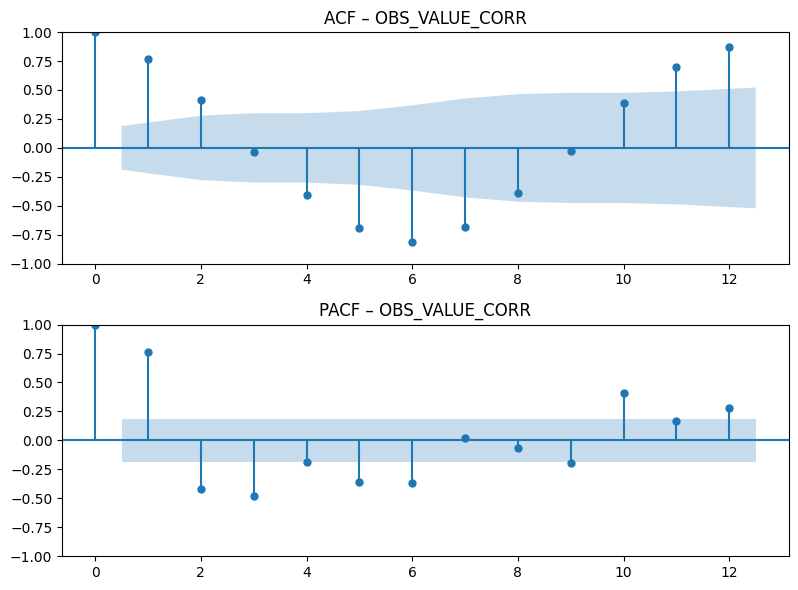

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:         OBS_VALUE_CORR   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     257.0
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           4.79e-66
Time:                        11:57:00   Log-Likelihood:                 138.57
No. Observations:                 108   AIC:                            -253.1
Df Residuals:                      96   BIC:                            -221.0
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

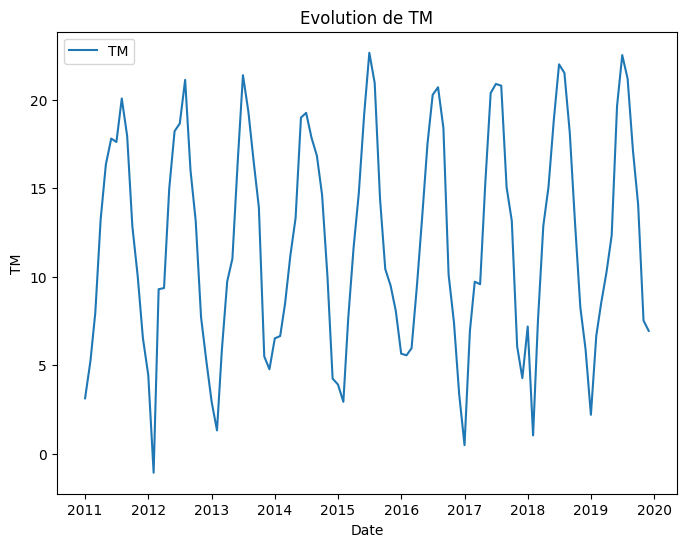

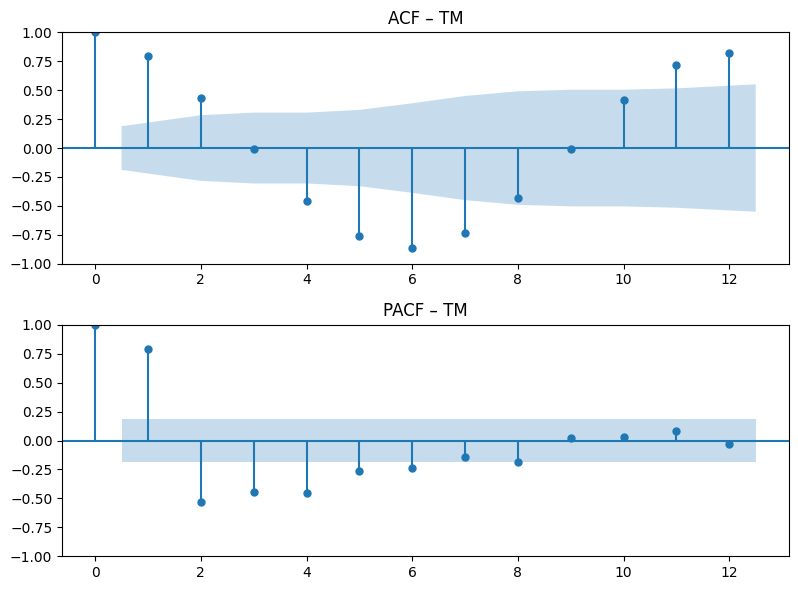

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     136.6
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           1.58e-53
Time:                        11:57:01   Log-Likelihood:                -204.85
No. Observations:                 108   AIC:                             433.7
Df Residuals:                      96   BIC:                             465.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

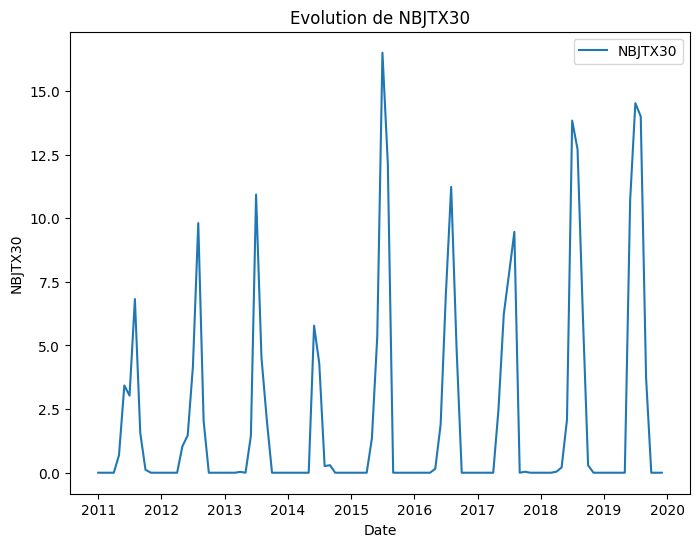

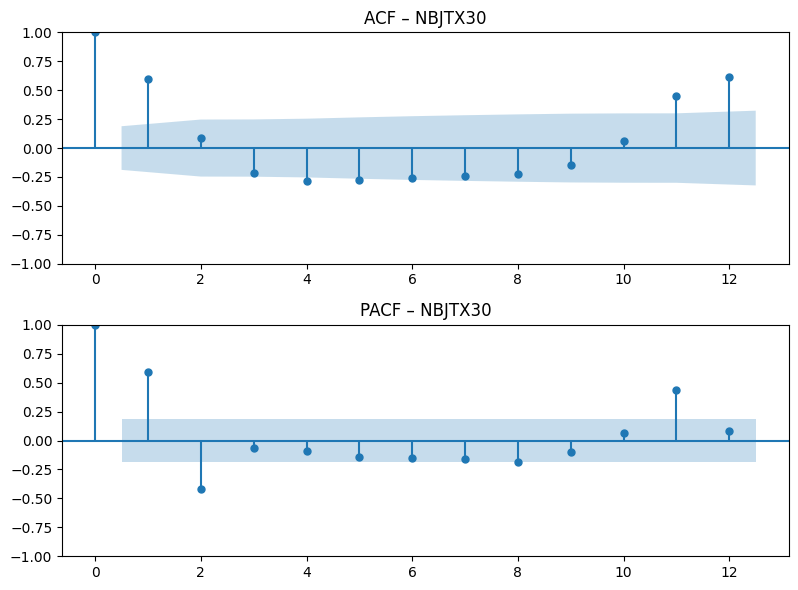

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJTX30   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     14.92
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           4.85e-13
Time:                        11:57:01   Log-Likelihood:                -233.39
No. Observations:                 108   AIC:                             490.8
Df Residuals:                      96   BIC:                             523.0
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

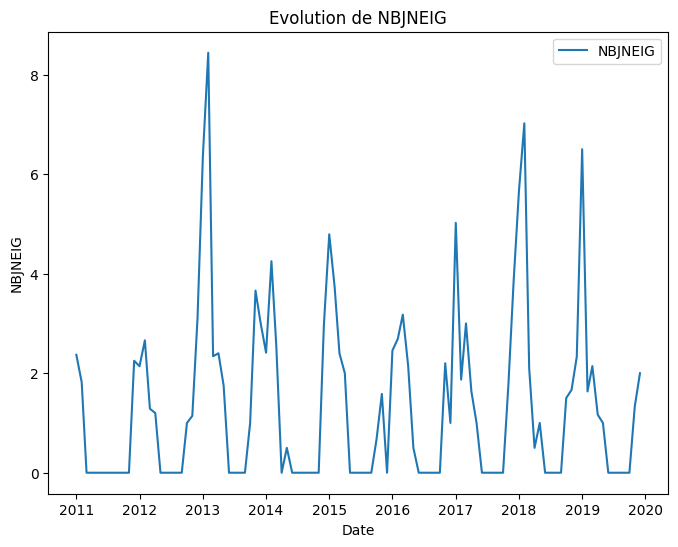

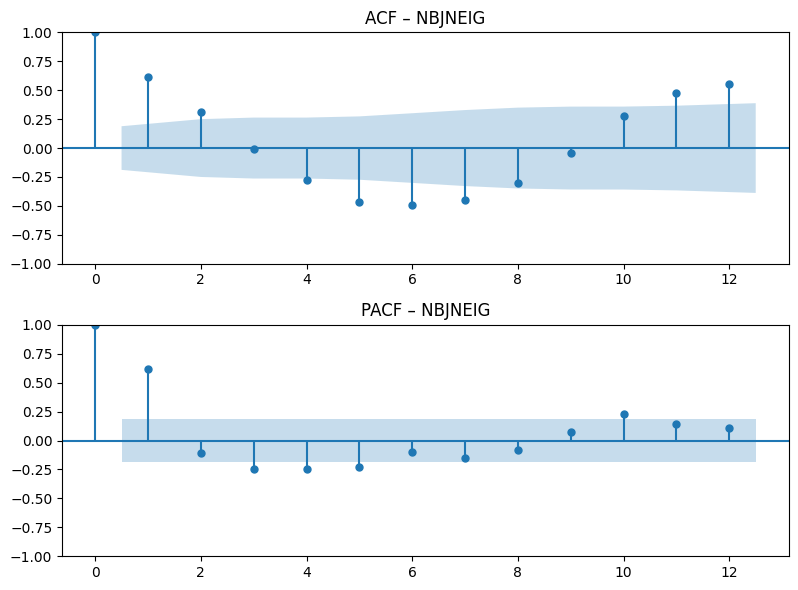

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJNEIG   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     24.32
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           5.26e-20
Time:                        11:57:01   Log-Likelihood:                -156.38
No. Observations:                 108   AIC:                             336.8
Df Residuals:                      96   BIC:                             368.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

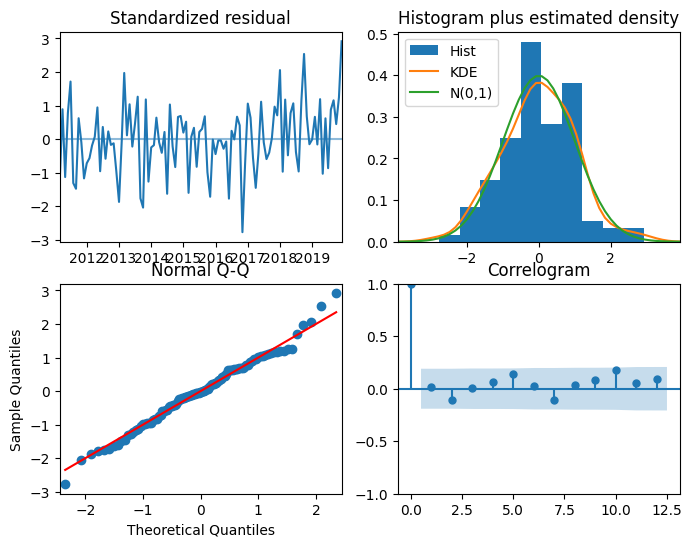

Rélation de long terme Analyse
                                UECM Model Results                                
Dep. Variable:           D.OBS_VALUE_CORR   No. Observations:                  108
Model:             Seas. UECM(2, 1, 1, 1)   Log Likelihood                 157.169
Method:                   Conditional MLE   S.D. of innovations             10.634
Date:                    Fri, 26 Dec 2025   AIC                           -278.338
Time:                            11:57:02   BIC                           -230.396
Sample:                        03-01-2011   HQIC                          -258.907
                             - 12-01-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8200      1.167      2.416      0.018       0.500       5.140
s(2,12)                 0.1925      0.034

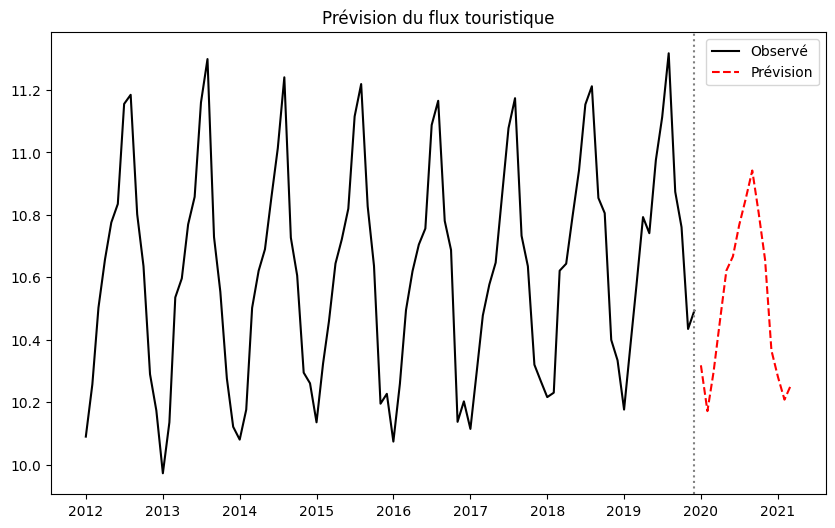

(3,
 'Allier',
 {2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2018: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2019: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2020: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2021: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2022: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 np.int64(0),
 ('Série corrigée de la saisonnalité déterministe', 1),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 'Il existe une relation de long terme entre le climat et les flux touristiques. Le changement climatique influence structurellement l’attractivité touristiqu

In [ ]:
from src.package_project.Test import Test, Resultat
Test(3)

In [ ]:
#cette cellule prend plus de 10 minutes 
t0 = time.perf_counter()
dataset = Resultat(95)
clear_output(wait=True)
t1 = time.perf_counter()
print(f"Temps d'execution : {t1 - t0:.3f}s")

Temps d'execution : 269.180s


In [ ]:
import pandas as pd
dataset.to_csv("dataset.csv")
dataset.head()

,departement,nom_dep,donne_pres,qualite,OBS_VALUE_CORR,TM,NBJTX30,NBJNEIG,conclusion,code
0,1.0,Ain,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
1,2.0,Aisne,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les résultats sont ambigus. La relation de lon...,incertain
2,3.0,Allier,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
3,4.0,Alpes-de-Haute-Provence,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les variables climatiques ne présentent pas d’...,mauvais
4,5.0,Hautes-Alpes,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon


In [ ]:
dataset.code.value_counts()

code
mauvais      58
bon          30
incertain     3
Name: count, dtype: int64

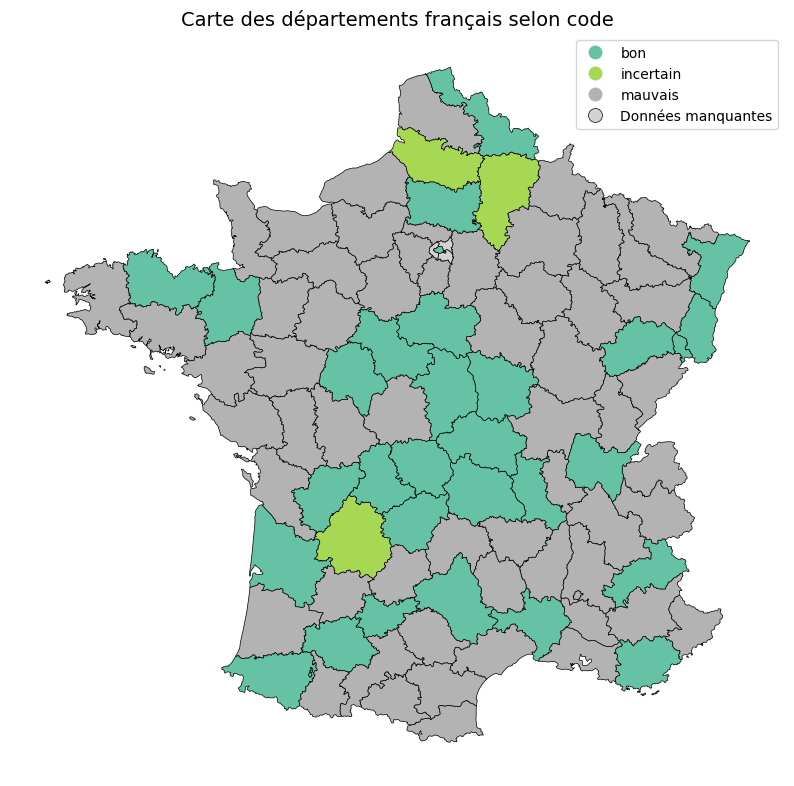

In [ ]:
dataset = pd.read_csv("dataset.csv")
from src.package_project.Carte_dyn import carte_departements
carte_departements(dataset)